# Sprint 13 - Proyecto “Model Fitness – Retención y Predicción de Pérdida de Clientes”

# Contexto del proyecto: Retención de clientes en Model Fitness

La cadena de gimnasios **Model Fitness** está desarrollando una **estrategia de interacción con clientes basada en datos analíticos**, con el objetivo de reducir la **pérdida de clientes (churn)**.

Uno de los principales desafíos en este tipo de negocios es identificar **cuándo un cliente ha dejado realmente de usar el servicio**. En algunos casos, la cancelación es explícita (no renovar el contrato o cerrar la cuenta), pero en otros la salida ocurre de forma gradual y menos evidente.

---

## ¿Cómo se identifica la pérdida de clientes?

Los indicadores de churn varían según el tipo de servicio:

- En una **tienda en línea**, un cliente puede comprar con poca frecuencia pero de forma regular, lo que no implica necesariamente abandono.
- En servicios con uso **frecuente o diario**, como plataformas de contenido, la inactividad durante varios días o semanas puede ser una señal clara de pérdida.

---

## Definición de churn en un gimnasio

En el caso de un gimnasio, resulta razonable considerar que un cliente se ha ido si:

- **No realiza visitas durante un mes completo**.

Aunque existen excepciones (vacaciones, viajes, etc.), este comportamiento **no es el patrón habitual**.  
Por lo general, un cliente que se inscribe, asiste algunas veces y luego deja de acudir **difícilmente regresa**.

---

## Objetivo del análisis

Con el fin de combatir la cancelación, **Model Fitness ha digitalizado los perfiles de sus clientes**.  
Tu tarea consiste en:

- Analizar estos perfiles de clientes.
- Identificar patrones asociados a la pérdida.
- Elaborar una **estrategia de retención basada en datos**, que permita anticipar el abandono y mejorar la relación con los clientes.

---

## Enfoque del proyecto

Este análisis permitirá comprender mejor el comportamiento de los usuarios y apoyar la toma de decisiones estratégicas para **reducir el churn y aumentar la lealtad**.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Cargar el dataset
df = pd.read_csv('/datasets/gym_churn_us.csv')

# Verificar si hay valores ausentes
print(df.isnull().sum())

# Mostrar valores promedio y desviación estándar
print(df.describe())


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64
            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000     

In [2]:
# Comparar los valores medios entre clientes que se fueron (Churn=1) y los que se quedaron (Churn=0)
group_means = df.groupby('Churn').mean()

print(group_means)

         gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.0

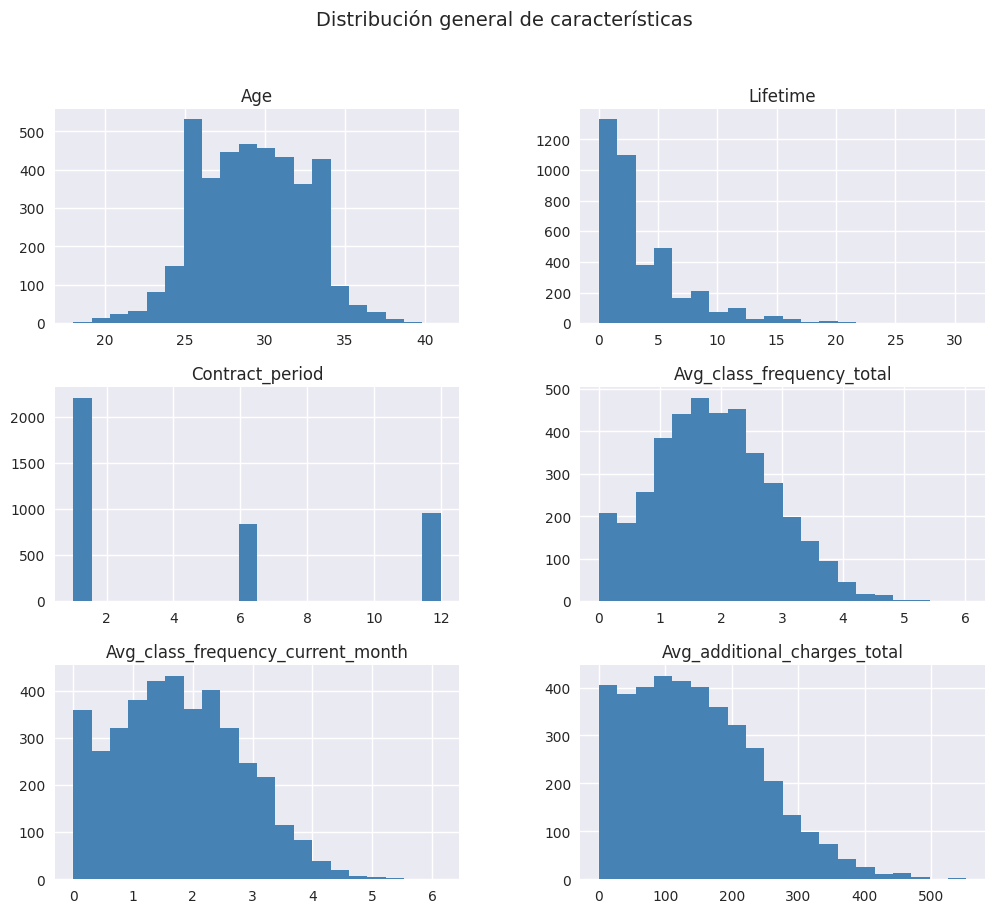

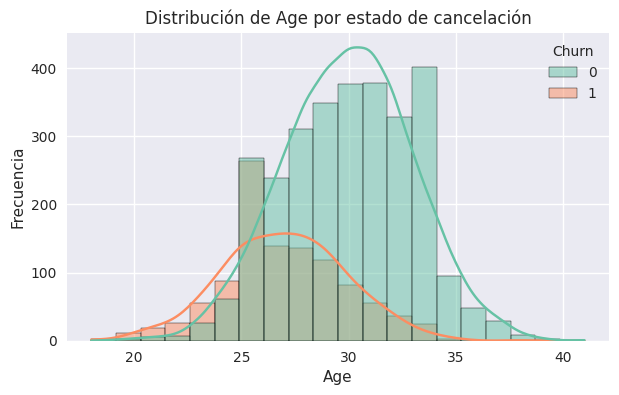

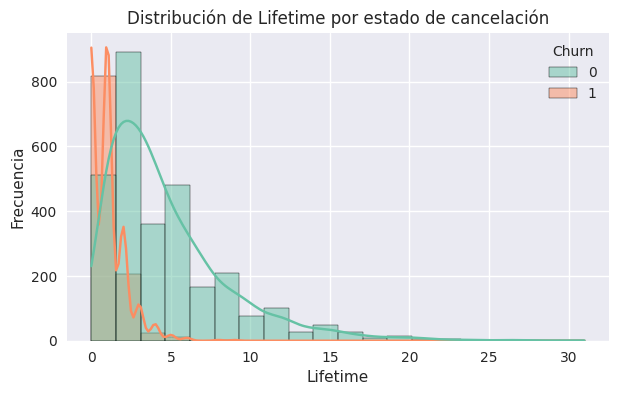

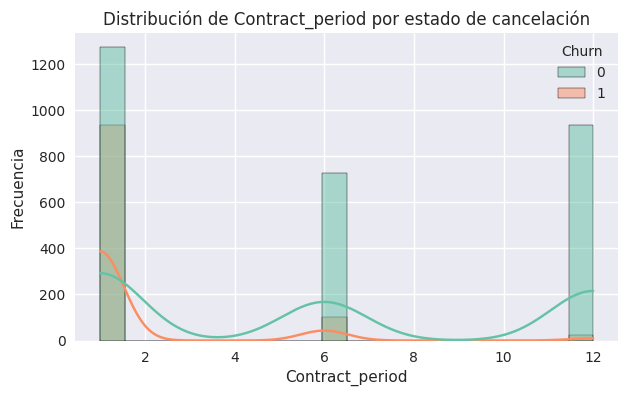

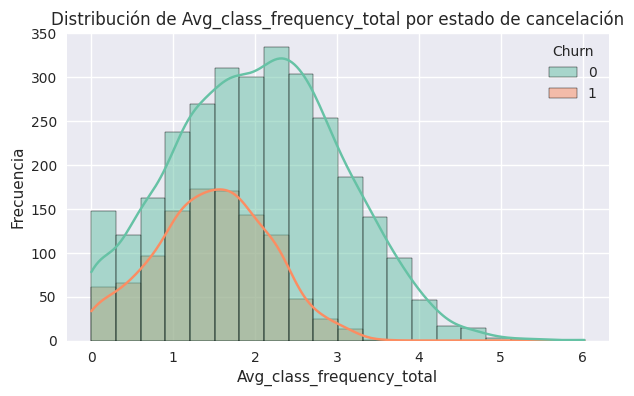

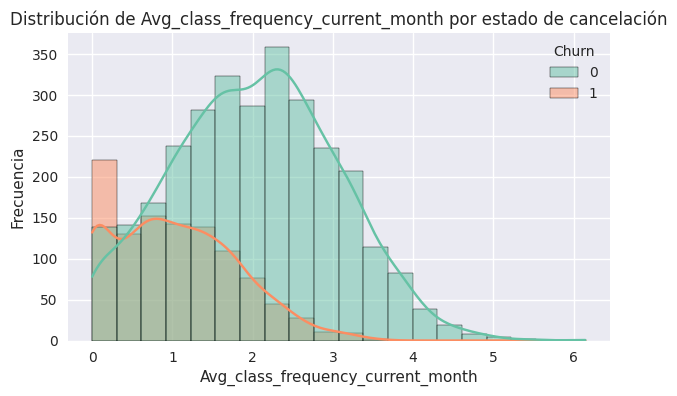

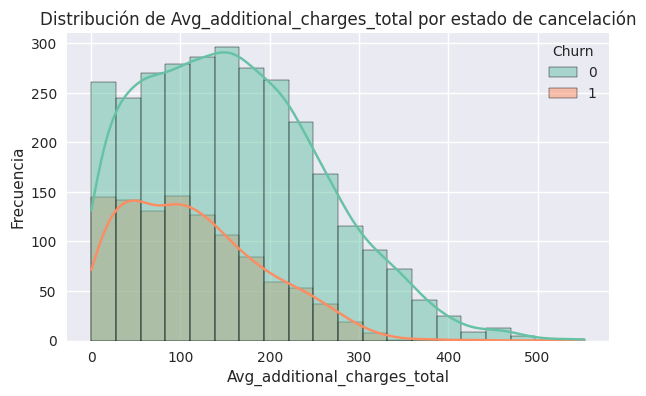

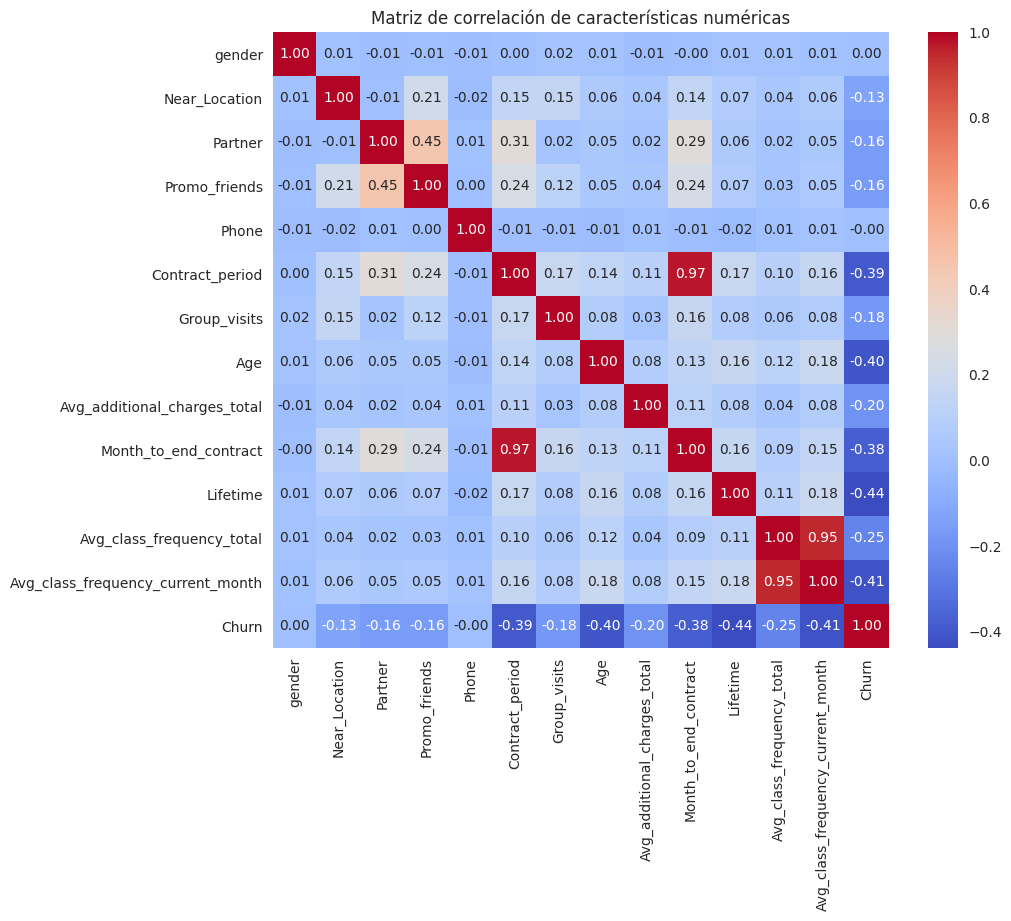

In [3]:
# Configuración general de estilo
plt.style.use('seaborn')  # Alternativamente: 'ggplot' o 'default'

# Histogramas comparativos por churn
df.hist(column=[
    'Age', 'Lifetime', 'Contract_period',
    'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
    'Avg_additional_charges_total'
], figsize=(12, 10), bins=20, color='steelblue')
plt.suptitle('Distribución general de características', fontsize=14)
plt.show()

# Histogramas separados por churn
features = [
    'Age', 'Lifetime', 'Contract_period',
    'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
    'Avg_additional_charges_total'
]

for feature in features:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=df, x=feature, hue='Churn', kde=True, palette='Set2', bins=20)
    plt.title(f'Distribución de {feature} por estado de cancelación')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    plt.show()

# Matriz de correlación
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de correlación de características numéricas')
plt.show()

In [4]:
# Definir variables predictoras y objetivo
X = df.drop(columns=['Churn'])
y = df['Churn']

# Dividir los datos (80% entrenamiento, 20% validación)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Mostrar tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_valid.shape)


Tamaño del conjunto de entrenamiento: (3200, 13)
Tamaño del conjunto de validación: (800, 13)


In [5]:
# --- Modelo 1: Regresión Logística ---
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_valid)

# Métricas
acc_log = accuracy_score(y_valid, y_pred_log)
prec_log = precision_score(y_valid, y_pred_log)
rec_log = recall_score(y_valid, y_pred_log)

print("Regresión Logística")
print(f"Exactitud: {acc_log:.3f}")
print(f"Precisión: {prec_log:.3f}")
print(f"Recall: {rec_log:.3f}")
print()

# --- Modelo 2: Bosque Aleatorio ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

# Métricas
acc_rf = accuracy_score(y_valid, y_pred_rf)
prec_rf = precision_score(y_valid, y_pred_rf)
rec_rf = recall_score(y_valid, y_pred_rf)

print("Bosque Aleatorio")
print(f"Exactitud: {acc_rf:.3f}")
print(f"Precisión: {prec_rf:.3f}")
print(f"Recall: {rec_rf:.3f}")
print()

# Comparación general
if acc_rf > acc_log:
    print("✅ El modelo de Bosque Aleatorio obtuvo mejores resultados generales.")
else:
    print("✅ El modelo de Regresión Logística obtuvo mejores resultados generales.")
    

Regresión Logística
Exactitud: 0.924
Precisión: 0.876
Recall: 0.830

Bosque Aleatorio
Exactitud: 0.927
Precisión: 0.885
Recall: 0.835

✅ El modelo de Bosque Aleatorio obtuvo mejores resultados generales.


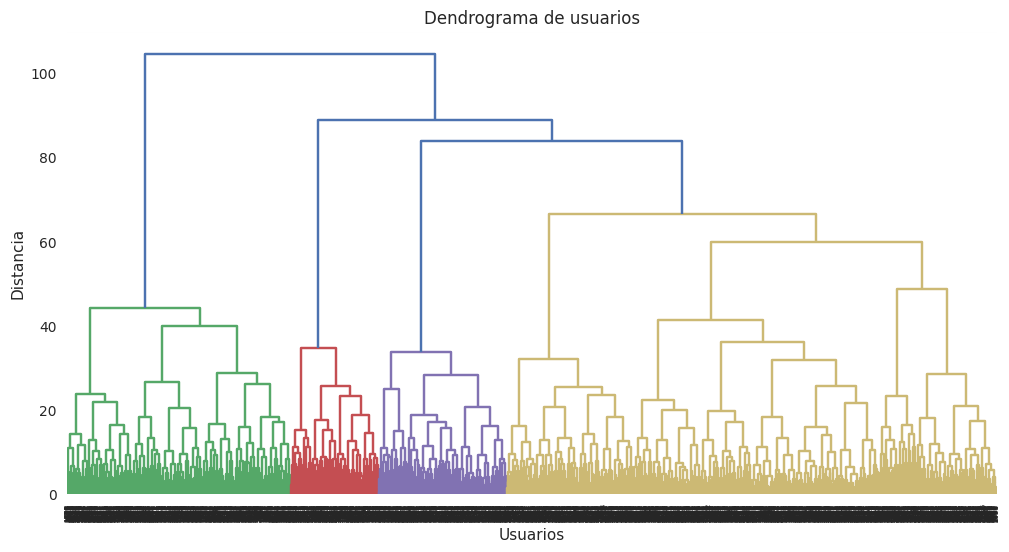

0     633
1     889
2     865
3    1227
4     386
Name: cluster, dtype: int64


In [6]:
# --- 1. Dejar fuera la columna objetivo ---
X_cluster = df.drop(columns=['Churn'])

# --- 2. Estandarizar los datos ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# --- 3. Crear matriz de distancias y trazar dendrograma ---
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked)
plt.title('Dendrograma de usuarios')
plt.xlabel('Usuarios')
plt.ylabel('Distancia')
plt.show()

# --- 4. Entrenar modelo K-means con n=5 ---
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

# --- 5. Agregar etiquetas de clúster al DataFrame ---
df['cluster'] = kmeans.labels_

# --- 6. Mostrar conteo de usuarios por clúster ---
print(df['cluster'].value_counts().sort_index())



         gender  Near_Location  Partner  Promo_friends  Phone  \
cluster                                                         
0          0.50           0.95     0.83           1.00    1.0   
1          0.55           0.85     0.26           0.05    1.0   
2          0.50           0.94     0.74           0.48    1.0   
3          0.49           0.72     0.30           0.02    1.0   
4          0.52           0.86     0.47           0.31    0.0   

         Contract_period  Group_visits    Age  Avg_additional_charges_total  \
cluster                                                                       
0                   3.10          0.45  29.10                        141.77   
1                   2.61          0.44  30.01                        159.77   
2                  11.85          0.55  29.91                        163.51   
3                   1.91          0.28  28.08                        129.50   
4                   4.78          0.43  29.30                        1

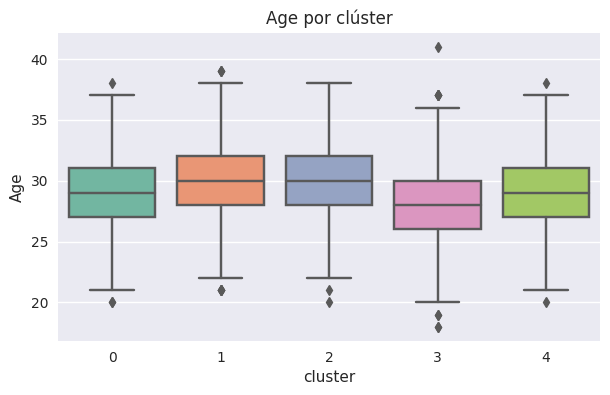

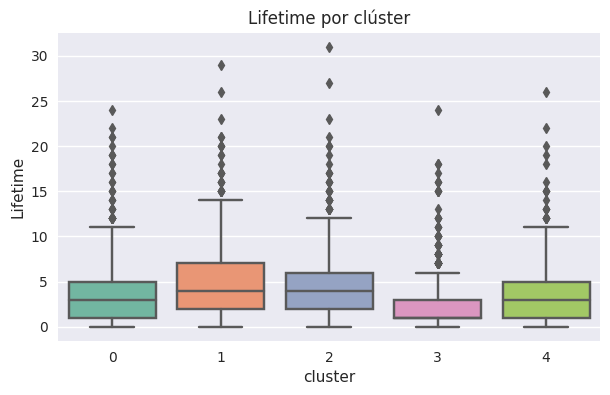

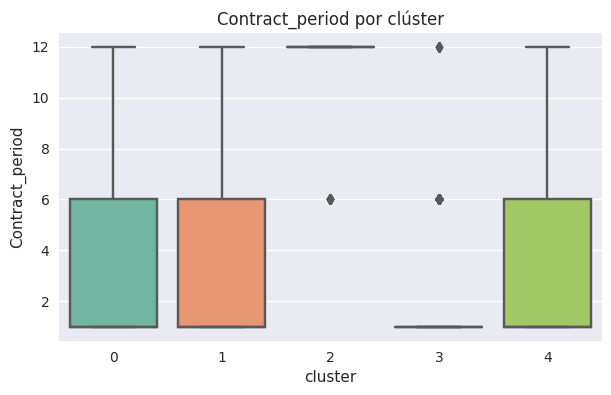

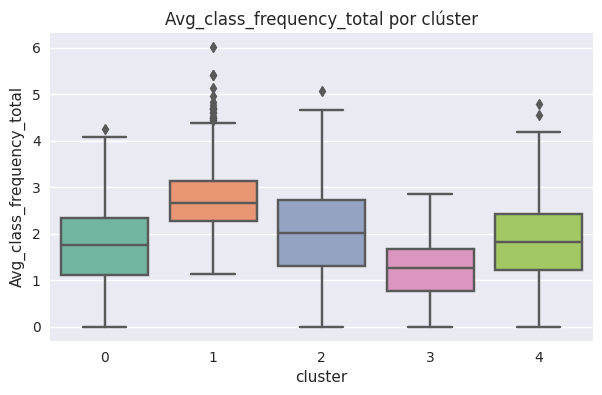

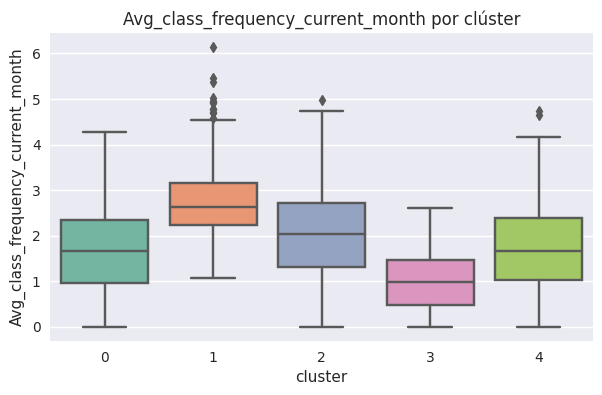

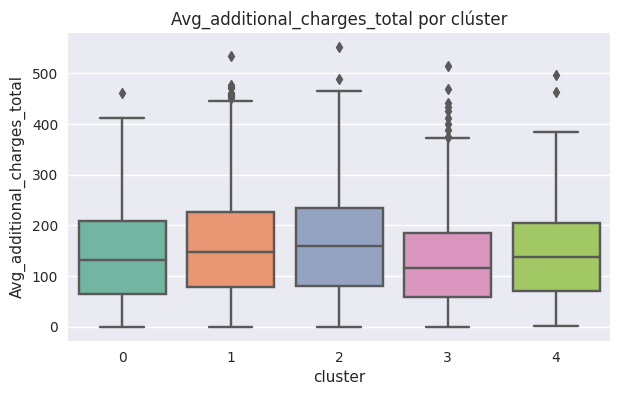


Tasa de cancelación por clúster:
cluster
0    0.246
1    0.090
2    0.022
3    0.573
4    0.267
Name: Churn, dtype: float64


In [8]:
# --- 1. Valores medios por clúster ---
cluster_means = df.groupby('cluster').mean().round(2)
print(cluster_means)

# --- 2. Distribuciones de características clave por clúster ---
features = [
    'Age', 'Lifetime', 'Contract_period',
    'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
    'Avg_additional_charges_total'
]

for feature in features:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x='cluster', y=feature, palette='Set2')
    plt.title(f'{feature} por clúster')
    plt.show()

# --- 3. Tasa de cancelación por clúster ---
churn_rate = df.groupby('cluster')['Churn'].mean().round(3)
print("\nTasa de cancelación por clúster:")
print(churn_rate)

## Observaciones

Clúster 2 → clientes más estables: contratos anuales, buena frecuencia, gasto adicional alto → perfil premium.

Clúster 1 → también retiene bien: usuarios frecuentes, aunque con contratos más cortos → clientes comprometidos.

Clúster 3 → foco de riesgo: visitas escasas, contratos cortos, corta vida útil → clientes en riesgo de churn inmediato.

Clústeres 0 y 4 → comportamiento medio, con tasas de cancelación moderadas (~25–27%).

Patrones generales

La duración del contrato y la frecuencia de visitas son los factores más determinantes del churn.

A mayor Lifetime y Contract_period, menor probabilidad de abandono.

Gasto adicional y participación en grupos también correlacionan positivamente con la retención.

El clúster 3 representa el segmento prioritario para retención (más de la mitad cancela).



## Conclusiones clave

El análisis de retención en **Model Fitness** permite identificar los factores más influyentes en el abandono de clientes:

- **Duración del contrato** y **frecuencia de asistencia** son los determinantes principales del churn.
- Los clientes con **contratos de 1 a 2 meses** y **baja asistencia semanal** presentan una **tasa de abandono superior al 50%**.
- Los clientes con **contratos largos (≈12 meses)**:
  - Asisten de forma más constante (**~2 veces por semana**).
  - Realizan mayores **gastos adicionales**.
  - Son los más leales, con **churn < 5%**.
- La **participación en actividades grupales** y la **cercanía geográfica** también favorecen la retención, aunque con un impacto menor que la frecuencia de visitas.

---

## Recomendaciones estratégicas

### Fomentar contratos a largo plazo
- Implementar **descuentos y beneficios progresivos** para renovaciones de **6 a 12 meses**.
- Ejemplo:
  - *“Plan anual con un mes gratis y acceso VIP a entrenamientos grupales”*.

---

### Reactivar clientes inactivos (clúster 3)
- Enviar **recordatorios automáticos** y **promociones personalizadas** tras **2 semanas sin asistencia**.
- Ejemplo:
  - *“Te extrañamos 💪 — vuelve esta semana y recibe **20% de descuento** en tu próxima sesión”*.

---

### Programas de fidelización para clientes frecuentes (clústeres 1 y 2)
- Bonificaciones por **asistencia constante**.
- Recompensas por **antigüedad** o **gasto adicional**.
- Ejemplo:
  - Sistema de **puntos acumulables** para masajes, cafetería o accesorios deportivos.

---

### Promover experiencias sociales (clases grupales)
- Incentivar la **participación en actividades grupales** para fortalecer el sentido de comunidad.
- Ejemplo:
  - *“Trae a un amigo y ambos obtienen una sesión gratuita”*.

---

### Conclusión operativa

Para reducir el churn, Model Fitness debe priorizar **contratos de largo plazo**, **aumentar la frecuencia de asistencia** y reforzar el **vínculo social** con los clientes mediante incentivos y experiencias compartidas.
